# GoingDeeper2. SentencePiece 사용하기

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
from konlpy.tag import Mecab
from tensorflow import keras

In [2]:
## SentencePiece 모델 학습

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


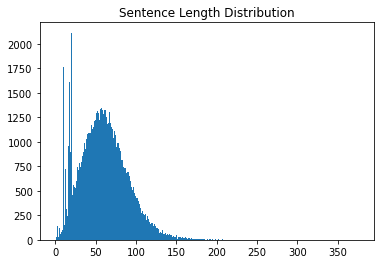

In [4]:
min_len=999
max_len=0
sum_len=0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len//len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1]+=1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [5]:
def check_sentence_with_length(raw, length):
    count=0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count>100: return
            
check_sentence_with_length(raw,1)

’


In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum>1500:
        print("Outlier index:", idx+1)

Outlier index: 11
Outlier index: 19
Outlier index: 21


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


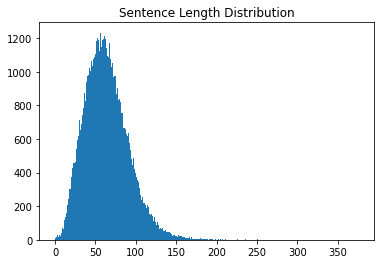

In [7]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

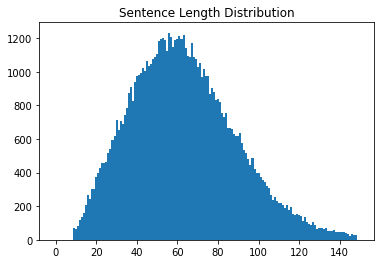

In [8]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s)<max_len)&(len(s)>=min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1]+=1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [9]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Sep 29 00:42 korean_spm.model
-rw-r--r-- 1 root root 146388 Sep 29 00:42 korean_spm.vocab


In [10]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Tokenizer 함수 작성

In [11]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [12]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1949 5662    5    4 7975 1983    3    0    0    0    0    0    0    0]
 [ 107 1638  101    4    0  419   11    4   14    0 1969    3    3    3]]


# 네이버 영화리뷰 감성분석에 SentencePiece 적용

네이버 영화 감정 분석 테스크는 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것입니다.  
이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 성능이 좋아질까요?  
* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece 적용시킨 모델 학습
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
* Word Vector는 활용이 가능하지 않을 것이니 활용할 필요가 없습니다.

## 데이터 로드

In [13]:
train_data = '~/aiffel/NLPGD/GD2/ratings_train.txt'
test_data =  '~/aiffel/NLPGD/GD2/ratings_test.txt'

In [14]:
train_data

'~/aiffel/NLPGD/GD2/ratings_train.txt'

In [15]:
train_data = pd.read_table(train_data)
test_data = pd.read_table(test_data)

In [16]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [17]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 데이터 전처리

### 중복, 결측치 제거

In [18]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [19]:
print(len(train_data), len(test_data))

150000 50000


In [20]:
print(train_data.nunique())
print(test_data.nunique())

id          150000
document    146182
label            2
dtype: int64
id          50000
document    49157
label           2
dtype: int64


In [21]:
train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거

In [22]:
train_data[train_data.document.isnull()]
test_data[test_data.document.isnull()]

,id,document,label
5746,402110,NaN,1


In [23]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any())
print(test_data.isnull().values.any())

False
False


In [24]:
print(len(train_data), len(test_data))

146182 49157


문장의 최대, 최소, 평균 길이를 구한 뒤 적정한 문장 길이를 선정합니다.

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


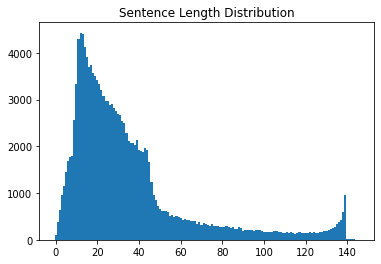

In [25]:
min_len=999
max_len=0
sum_len=0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len//len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1]+=1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [26]:
def check_sentence_with_length(train_data, length):
    count=0
    
    for sen in train_data['document']:
        if len(sen) == length:
            print(sen)
            count += 1
            if count>100: return
            
check_sentence_with_length(train_data,1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [27]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 4000을 초과하는 문장 길이를 추출합니다.
    if _sum>4000:
        print("Outlier index:", idx+1)

Outlier index: 12
Outlier index: 13
Outlier index: 14
Outlier index: 15


In [28]:
check_sentence_with_length(train_data, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

문장의 최대 길이는 100, 최소 길이는 2로 지정하겠습니다.

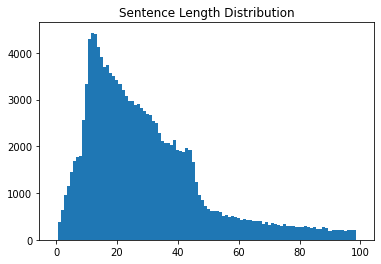

In [29]:
max_len = 100
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in train_data['document'] if (len(s)<max_len)&(len(s)>=min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1]+=1
    
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [30]:
train_data['document'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [31]:
# 한글, 자음, 모음, 영어, 스페이스를 제외한 나머지를 스페이스로 치환
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]"," ")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]"," ")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
train_data['document'][0]

'아 더빙   진짜 짜증나네요 목소리'

In [33]:
# 공백 여러개 제거
train_data['document'] = train_data['document'].str.replace(' +', ' ')
test_data['document'] = test_data['document'].str.replace(' +', ' ')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
train_data['document'][0]

'아 더빙 진짜 짜증나네요 목소리'

In [35]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


## 모델 학습

## SentencePiece를 적용시킨 모델 학습하기

In [36]:
import sentencepiece as spm
import os

# train_data에서 텍스트 부분만 추출
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/naver.csv'
train_data['document'].to_csv(temp_file, index=False, header=False)

In [37]:
vocab_size = 8000
model_prefix = 'naver_spm'

        
spm.SentencePieceTrainer.Train(
'--input={} --model_prefix={} --vocab_size={}'.format(temp_file, model_prefix ,vocab_size)
)

## 학습된 모델로 sp_tokenize() 메소드 구현하기
1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다. 
2. 생성된 vocab 파일을 읽어와 { \<word> : \<idx> } 형태를 가지는 word_index 사전과 { \<idx> : \<word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.  
3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. Padding 또한 적용해줍니다.

In [38]:
import sentencepiece as spm
s = spm.SentencePieceProcessor()
s.Load('naver_spm.model')

True

In [39]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({idx:word})
        index_word.update({word:idx})
        
#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, word_index, index_word

In [40]:
X_train, word_index, index_word = sp_tokenize(s, train_data['document'])

## 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기

### Label 만들어 주기

In [41]:
X_test = [s.EncodeAsIds(x) for x in test_data['document']]

In [42]:
X_train[0]

[52, 761, 24, 1888, 50, 1652]

In [43]:
len(X_train), len(X_test)

(146182, 49157)

In [44]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [45]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

146182 49157
146182 49157


In [46]:
# 패딩
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post')

### 모델 학습

In [47]:
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 128,881
Trainable params: 128,881
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.2, verbose=1)

Epoch 1/20
229/229 [==============================] - 10s 30ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4961
Epoch 2/20
229/229 [==============================] - 6s 27ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 3/20
229/229 [==============================] - 6s 27ms/step - loss: 0.6931 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 4/20
229/229 [==============================] - 6s 27ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 5/20
229/229 [==============================] - 6s 27ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 6/20
229/229 [==============================] - 6s 27ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 7/20
229/229 [==============================] - 6s 27ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.503

In [49]:
results = model.evaluate(X_test, y_test, verbose=2)

1537/1537 - 11s - loss: 0.6932 - accuracy: 0.4973


## KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [68]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [69]:
len(train_data), len(test_data)

(146182, 49157)

In [70]:
mecab = Mecab()

In [71]:
mecab.morphs(train_data['document'][0])

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']

In [76]:
def mecab_split(data):
    return mecab.morphs(data)

mecab_corpus = []
for i in train_data['document']:
    mecab_corpus.append(mecab_split(i))

In [77]:
mecab_corpus[0:4]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없', '다', '평점', '조정']]

In [116]:
test_data['document']

0                                                  굳 ㅋ
1                                 GDNTOPCLASSINTHECLUB
2                     뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
3                           지루하지는 않은데 완전 막장임 돈주고 보기에는 
4         D만 아니었어도 별 다섯 개 줬을텐데 왜 D로 나와서 제 심기를 불편하게 하죠 
                             ...                      
49995        오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
49996     의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
49997                  그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다
49998       절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네
49999                                       마무리는 또 왜이래
Name: document, Length: 49157, dtype: object

In [117]:
train_token_len_list = [len(token) for token in mecab_corpus]
test_token_len_list = [len(token) for token in test_data['document']]
total_token_len_list = [train_token_len_list + test_token_len_list]

In [118]:
print('문장 길이 평균:', np.mean(total_token_len_list))
print('문장 최대 길이:', np.max(total_token_len_list))
print('문장 최소 길이:', np.min(total_token_len_list))

문장 길이 평균: 20.943672282544703
문장 최대 길이: 140
문장 최소 길이: 0


In [119]:
mecab_max_token = np.mean(total_token_len_list)+90
max_num_token = np.max(total_token_len_list)
print(f'전체 문장의 {(mecab_max_token/max_num_token)*100}%가 maxlen 설정값 이내에 포함됩니다.')

전체 문장의 79.24548020181764%가 maxlen 설정값 이내에 포함됩니다.


In [120]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [121]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

In [122]:
print('단어사전 길이:', len(mecab_tokenizer.index_word))

단어사전 길이: 51210


In [136]:
mecab_x_test_tensor = mecab_tokenizer.texts_to_sequences(mecab_x_test_token)
mecab_x_test_tensor = tf.keras.preprocessing.sequence.pad_sequences(mecab_x_test_tensor, padding='post')

In [167]:
mecab_x_test_tensor

array([[ 803,  132,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [  89,  120,    1, ...,    0,    0,    0],
       ...,
       [1006,    7,   21, ...,    0,    0,    0],
       [ 399,  476,    2, ...,    0,    0,    0],
       [ 974,    2,  178, ...,    0,    0,    0]], dtype=int32)

In [138]:
len(mecab_x_test_tensor)

49157

In [143]:
mecab_x_train = mecab_tensor
mecab_y_train = np.array(train_data['label'])
mecab_x_test = mecab_x_test_tensor
mecab_y_test = np.array(test_data['label'])

In [160]:
print(len(mecab_x_train), len(mecab_y_train))
print(len(mecab_x_test), len(mecab_y_test))

146182 146182
49157 49157


In [150]:
vocab_size2 = len(mecab_tokenizer.index_word)
vocab_size2

51210

In [170]:
word_vector_dim = 16

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size2+1, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          819376    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 820,257
Trainable params: 820,257
Non-trainable params: 0
_________________________________________________________________


In [171]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mecab_history = model2.fit(mecab_x_train, mecab_y_train, epochs=20, batch_size=512, validation_split=0.2, verbose=1)

Epoch 1/20
229/229 [==============================] - 8s 24ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 2/20
229/229 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6932 - val_accuracy: 0.4961
Epoch 3/20
229/229 [==============================] - 5s 22ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 4/20
229/229 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 5/20
229/229 [==============================] - 5s 22ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.4961
Epoch 6/20
229/229 [==============================] - 5s 22ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 7/20
229/229 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5039

In [172]:
mecab_results = model2.evaluate(mecab_x_test, mecab_y_test, verbose=2)

1537/1537 - 10s - loss: 0.6702 - accuracy: 0.5637
